In [159]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pypulseq as pp
import matplotlib.pyplot as plt

from diff_epi_tools import make_diff_epirs, plot_trajectory

import sys
sys.path.append("/Users/arielhannum/Documents/GitHub/gropt/python")
import gropt

sys.path.append("../")
from gropt_waveforms import *
from trap_waveforms import *
import os

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [160]:
max_slew_diffusion = 178#178 or 43
pns_thresh = None
max_grad = 43 # 38 or 200
mode = 'Brain'
ii = 0
waveform  = 'T' # T = Trap or G = Gropt
system = pp.Opts()

In [161]:
heart_bval = [350,500]
liver_bval = [600,800]
brain_bval = [1000,2000]

Brain = {'Nx':140,
        'Ny':140,
        'fovx': 210e-3, 
        'fovy': 210e-3, 
        'partial_fourier': 6/8, 
        'slice_thickness': 2e-3,
        'b': brain_bval[ii],
        'MMT':0,
        'T_90':1.59,
        'T_180':3.92,
        'T_readout': 25.85
}

Liver = {'Nx':128,
        'Ny':128,
        'fovx': 384e-3, 
        'fovy': 384e-3, 
        'partial_fourier':  6/8, 
        'slice_thickness': 6e-3,
        'b':liver_bval[ii],
        'MMT':1,
        'T_90':1.59,
        'T_180':3.92,
        'T_readout': 13.75
}

Heart = {'Nx':128,
        'Ny':128,
        'fovx': 256e-3, 
        'fovy': 256*1e-3, 
        'partial_fourier':  6/8, 
        'slice_thickness': 8e-3,
        'b':heart_bval[ii],
        'MMT':2,
        'T_90':1.59,
        'T_180':3.92,
        'T_readout': 16.1
}


if pns_thresh == None:
    folder = 'Exp-1'
elif pns_thresh == 0.95 and max_slew_diffusion == 178:
    folder = 'Exp-2'
elif pns_thresh == 0.95 and max_slew_diffusion == 43:
    folder = 'Exp-3'

if max_grad == 200:
    scanner = 'High'

if max_grad == 38:
    scanner = 'Conv'


if mode =='Brain': 
    input_args = Brain
if mode =='Liver': 
    input_args = Liver
if mode =='Heart': 
    input_args = Heart
    
input_args['pns_thresh'] = pns_thresh


matsave = os.path.join('Waveforms-Sim3',folder, scanner,mode + '_' + waveform + '_b'+str(input_args['b'])+'_pns'+str(input_args['pns_thresh'])+'_s'+str(max_slew_diffusion))
if not os.path.exists(os.path.join('Waveforms-Sim3',folder, scanner)):
    os.makedirs(os.path.join('Waveforms-Sim3',folder, scanner))

print(matsave)
input_args

Waveforms-Sim3/Exp-1/High/Brain_T_b1000_pnsNone_s178


{'Nx': 140,
 'Ny': 140,
 'fovx': 0.21,
 'fovy': 0.21,
 'partial_fourier': 0.75,
 'slice_thickness': 0.002,
 'b': 1000,
 'MMT': 0,
 'T_90': 1.59,
 'T_180': 3.92,
 'T_readout': 25.85,
 'pns_thresh': None}

In [162]:
# Here we initialize designing the gradient whether it is a TRAP or GROPT Waveform 
params = {
        'gmax':max_grad, #mT/m --> Lower this a little to like 38
        'smax':max_slew_diffusion, #T/m/ms --> Lower this a little to like 190
        'T_readout':  input_args['T_readout'], #ms
        'T_90': input_args['T_90'], #ms
        'T_180': input_args['T_180'], #ms
        'mode' : 'diff_bval',
        'MMT' : input_args['MMT'], # either [0, 1, 2] depending on level of motion compensation
        'b': input_args['b'], # s/mm2,
    }
    
if mode == 'Heart' and params['b'] == 500:
        params['gmax']-=2#2


if pns_thresh is not None:
        params['pns_thresh'] = pns_thresh

if waveform =='T': #We do TRAPS 
    params['dt'] =1e-5 # system.grad_raster_time
    params['gmax'] -=1

    if pns_thresh == None:
            params['pns_thresh'] = 3
            pns_thresh = 3

    start_bval = params['b']
    gradient,Time,T_start,start_bval,p,= calc_trap(params.copy(),0.005,pns_thresh)
    params['TE']  = T_start
    print('TE = {:.2f}'.format(T_start))


elif waveform == 'G':
    params['dt'] = 3e-5
    trap_params = params.copy()
    trap_params['gmax'] = 100
    gradient,Time,T_start,start_bval,p,= calc_trap(trap_params.copy(),0.001,4)
    start_bval = params['b']
    #T_start = 150
    params['dt'] = 8e-5
    
    params2, gradient, te_track, b_track= calc_grop_hybrid(params.copy(), start_bval, T_start, 0.01, iterations=60)
    params = params2.copy()
print('TE = {:.2f} ms'.format(params['TE']))

	PNS is 1.27
TE = 85.41
TE = 85.41 ms


Bval = 995.85s/mm2


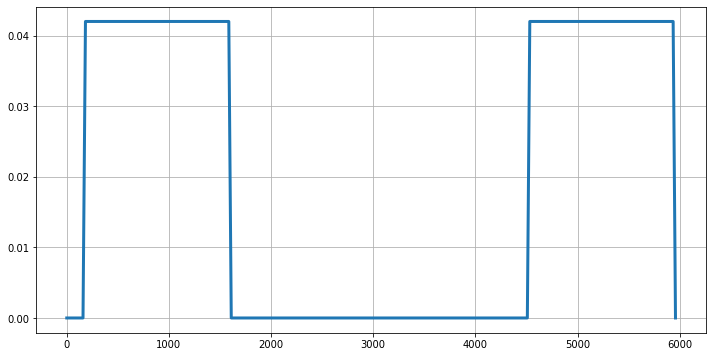

In [163]:
# Recompute G for gropt so it is the raster timing 
if waveform == 'T':
    params['TE'] = T_start*1e-3
    params['dt_out'] = system.grad_raster_time
    bval_params=params.copy()
    test = get_bval(gradient,bval_params)
    print('Bval = {:.2f}s/mm2'.format(test))

    
if waveform == 'G':
    params['dt_out'] = system.grad_raster_time
    gradient,_ = gropt.gropt(params.copy())
    bval_params=params.copy()
    bval_params['dt'] = system.grad_raster_time
    test = get_bval(gradient,bval_params)
    print('Bval = {:.2f}s/mm2'.format(test))
    params['TE'] = params['TE']*1e-3

# Recompute Timings for Our TE
G= np.squeeze(gradient)

time = np.linspace(0,len(G),len(G))
plt.figure(figsize=(12,6))
plt.grid()
plt.plot(time,G,linewidth =3 )
#plt.plot(time[seg1_start:seg1_stop],diff_grad1,linewidth =3 )
#plt.plot(time[seg2_start:seg2_stop],diff_grad2,linewidth =3 )
plt.show()

In [164]:
from scipy.io import savemat
save_params = params.copy()

save_params['TE'] = params['TE']*1e3
save_params['Grad'] = G
save_params['Time'] = time

savemat(matsave + '.mat',save_params)

In [165]:
save_params['TE']

85.41286516853859

In [166]:
save_params

{'gmax': 42,
 'smax': 178,
 'T_readout': 25.85,
 'T_90': 1.59,
 'T_180': 3.92,
 'mode': 'diff_bval',
 'MMT': 0,
 'b': 1000,
 'dt': 1e-05,
 'pns_thresh': 3,
 'TE': 85.41286516853859,
 'dt_out': 1e-05,
 'Grad': array([0.        , 0.        , 0.        , ..., 0.00365217, 0.00182609,
        0.        ]),
 'Time': array([0.00000000e+00, 1.00016784e+00, 2.00033568e+00, ...,
        5.95699966e+03, 5.95799983e+03, 5.95900000e+03])}